In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, \
mean_absolute_percentage_error, mean_squared_log_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings("ignore");

RAND = 10

**Задача**:

- - Главная задача, поэксперементировать и построить модель без EDA анализа и feauture engineering'а(понимания наших данных), но при этом попытаться затюнить модель и показать неплохой скор 
    
- - Пояснение таска:

    - Требуется построить модель, предсказывающую страховую стоимость транспортного средства клиента (признак target) для 3662 договоров из тестового набора данных (файл casco_test.csv).
    
    - Метрикой качества является средняя относительная ошибка предсказания (Mean Absolute Percentage Error)
    
    - Целевая переменная - TARGET. Стоимость каско для конкретного клиента по предоставленным признакам.

# Описание полей / Data Description

- column_1 - пол водителя / gender of the driver;
- column_2 - стаж вождения / driving experience;
- column_3 - семейное положение водителя / marital status of the driver;
- column_4 - город регистрации водителя / city of driver registration;
- column_5 - город регистрации договора / city of contract registration;
- column_6 - максимальная просрочка по выплатам / maximum delay in payments;
- column_7 - тип двигателя / engine type;
- column_8 - пробег транспортного средства / vehicle mileage;
- column_9 - год производства транспортного средства / vehicle manufacturing year;
- column_10 - мощность двигателя в лошадиных силах / engine power in horsepower;
- column_11 - количество договоров клиента / number of client contracts;
- column_12 - количество договоров транспортного средства / number of vehicle contracts;
- column_13 - возраст клиента / client age;
- column_14 - тип транспортного средства / vehicle type;
- column_15 - страна-производитель транспортного средства / vehicle manufacturing country;
- column_16 - наличие телематических систем, установленных на транспортное средство / the presence of telematics systems installed on the vehicle;
- column_17 - марка и модель автомобиля (задача усложняется тем, что в выборке почти для всех марок присутствуют разные модели, представляющие их, т.е. марка X в выборке представлена моделями x1,x2, хотя в явном виде эта информация в данных не присутствует) / brand and model of the car (the task is complicated by the fact that in the sample for almost all brands there are different models representing them, i.e. brand X in the sample is represented by models x1, x2, although this information is not explicitly present in the data);
- column_18 - технический параметр транспортного средства / technical parameter of the vehicle.
- В тестовом наборе данных каждому договору соответствует уникальный идентификатор id.

# Импорт данных

In [3]:
test = pd.read_csv('../Kaggle/casco_test.csv')
train = pd.read_csv('../Kaggle/casco_train.csv')

In [4]:
train

column_1   column_2 column_3 column_4 column_5   column_6 column_7  \
0             2  15.065199       a1       b0       b0  53.000000       q2   
1             1  12.200897       a3       b0       b0   6.000000       q1   
2             2  50.337125       a1       b4       b4  10.155556       q1   
3             1  20.731525       a1      b86       b0   0.000000       q2   
4             2  51.628454       a1       b0       b0  37.000000       q1   
...         ...        ...      ...      ...      ...        ...      ...   
24506         1  26.305265       a1       b0       b0  46.000000       q1   
24507         2  24.920571       a1       b0       b0   4.000000       q1   
24508         2  17.909612       a3       b0       b0   0.000000       q1   
24509         2  20.731525       a1    b1830    b1830  51.000000       q1   
24510         2   6.447149       a1       b3       b3  37.000000       q1   

       column_8  column_9  column_10  column_11  column_12  column_13  \
0           1.0         2      249.0         23          1  58.025786   
1        2100.0         4      123.0          4          3  81.549097   
2           1.0         2      181.0          9          0  76.689904   
3       60000.0         7      211.0         29          0  79.125201   
4       48065.0         7      209.0         19          0  81.549097   
...         ...       ...        ...        ...        ...        ...   
24506   41300.0         7      141.0         17          3  65.580824   
24507   24100.0         4      224.0         17          2  76.689904   
24508   22000.0         5      141.0          6          2  54.199037   
24509   61988.0         9      281.0         19          0  55.478435   
24510       1.0         6      241.0         22          1  51.628454   

       column_14 column_15  column_16 column_17  column_18        target  
0              1        c4          1         k   3.095619  3.105288e+06  
1              1        c0          0         a   1.665975  3.752557e+05  
2              1        c3          1         j   4.265557  9.910123e+05  
3              1        c4          0         f   5.201468  9.389850e+05  
4              1        c1          0         h   6.136154  7.761075e+05  
...          ...       ...        ...       ...        ...           ...  
24506          1        c3          0         d   5.596123  4.865263e+05  
24507          1        c4          0         f   6.303270  1.223845e+06  
24508          1        c3          0         d   2.790665  4.951634e+05  
24509          1        c1          0         j   5.923236  1.083849e+06  
24510          1        c1          0         i   3.851706  1.230180e+06  

[24511 rows x 19 columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24511 entries, 0 to 24510
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   column_1   24511 non-null  int64  
 1   column_2   24425 non-null  float64
 2   column_3   24511 non-null  object 
 3   column_4   24511 non-null  object 
 4   column_5   24511 non-null  object 
 5   column_6   24511 non-null  float64
 6   column_7   24511 non-null  object 
 7   column_8   24511 non-null  float64
 8   column_9   24511 non-null  int64  
 9   column_10  24511 non-null  float64
 10  column_11  24511 non-null  int64  
 11  column_12  24511 non-null  int64  
 12  column_13  24511 non-null  float64
 13  column_14  24511 non-null  int64  
 14  column_15  24511 non-null  object 
 15  column_16  24511 non-null  int64  
 16  column_17  24511 non-null  object 
 17  column_18  24511 non-null  float64
 18  target     24511 non-null  float64
dtypes: float64(7), int64(6), object(6)
memory usag

In [6]:
train.describe()

column_1      column_2      column_6       column_8      column_9  \
count  24511.000000  24425.000000  24511.000000   24511.000000  24511.000000   
mean       1.637346     23.368763     26.023593   29149.379999      5.159969   
std        0.480776     12.825861     28.646634   30282.588186      1.575513   
min        1.000000      0.000000      0.000000       0.000000      1.000000   
25%        1.000000     13.635261      5.000000    5000.000000      4.000000   
50%        2.000000     20.731525     20.607639   21000.000000      5.000000   
75%        2.000000     29.057520     40.000000   44000.000000      6.000000   
max        2.000000     82.756867    824.000000  472000.000000     11.000000   

          column_10     column_11     column_12     column_13  column_14  \
count  24511.000000  24511.000000  24511.000000  24511.000000    24511.0   
mean     179.652861     15.031374      1.155767     62.461746        1.0   
std       60.968674     14.117775      1.630209     14.203218        0.0   
min       77.000000      0.000000      0.000000     26.305265        1.0   
25%      140.000000      6.000000      0.000000     51.628454        1.0   
50%      173.000000     11.000000      1.000000     60.558310        1.0   
75%      211.000000     20.000000      2.000000     73.014864        1.0   
max     1984.000000    239.000000     22.000000    113.291520        1.0   

          column_16     column_18        target  
count  24511.000000  24511.000000  2.451100e+04  
mean       0.087675      4.005307  8.598488e+05  
std        0.282827      2.044430  6.200979e+05  
min        0.000000     -0.594558  2.318534e+05  
25%        0.000000      2.237893  4.351764e+05  
50%        0.000000      4.020274  6.785568e+05  
75%        0.000000      5.782849  1.075320e+06  
max        1.000000      8.663453  4.833195e+06

In [7]:
print('Number of train files: {}'.format(len(train)))
print('Number of test files: {}'.format(len(test )))

Number of train files: 24511
Number of test files: 3662


# Проверим данные на выбросы

In [8]:
# отобразим все столбцы в таблице

pd.set_option('display.max_columns', None)

In [10]:
train.describe(include='O')

column_3 column_4 column_5 column_7 column_15 column_17
count     24511    24511    24511    24511     24511     24511
unique        7      822      789        7         8        11
top          a1       b0       b0       q1        c4         e
freq      19161    17693    17770    19568      9360      4996

In [9]:
train.describe()

column_1      column_2      column_6       column_8      column_9  \
count  24511.000000  24425.000000  24511.000000   24511.000000  24511.000000   
mean       1.637346     23.368763     26.023593   29149.379999      5.159969   
std        0.480776     12.825861     28.646634   30282.588186      1.575513   
min        1.000000      0.000000      0.000000       0.000000      1.000000   
25%        1.000000     13.635261      5.000000    5000.000000      4.000000   
50%        2.000000     20.731525     20.607639   21000.000000      5.000000   
75%        2.000000     29.057520     40.000000   44000.000000      6.000000   
max        2.000000     82.756867    824.000000  472000.000000     11.000000   

          column_10     column_11     column_12     column_13  column_14  \
count  24511.000000  24511.000000  24511.000000  24511.000000    24511.0   
mean     179.652861     15.031374      1.155767     62.461746        1.0   
std       60.968674     14.117775      1.630209     14.203218        0.0   
min       77.000000      0.000000      0.000000     26.305265        1.0   
25%      140.000000      6.000000      0.000000     51.628454        1.0   
50%      173.000000     11.000000      1.000000     60.558310        1.0   
75%      211.000000     20.000000      2.000000     73.014864        1.0   
max     1984.000000    239.000000     22.000000    113.291520        1.0   

          column_16     column_18        target  
count  24511.000000  24511.000000  2.451100e+04  
mean       0.087675      4.005307  8.598488e+05  
std        0.282827      2.044430  6.200979e+05  
min        0.000000     -0.594558  2.318534e+05  
25%        0.000000      2.237893  4.351764e+05  
50%        0.000000      4.020274  6.785568e+05  
75%        0.000000      5.782849  1.075320e+06  
max        1.000000      8.663453  4.833195e+06

По максимальным - минимальным значениям смотрим на данные и проверяем их на корректность 

In [13]:
# column_10 - мощность двигателя в лошадиных силах

train[train['column_10'] > 700]

column_1   column_2 column_3 column_4 column_5  column_6 column_7  \
1734          1  19.323463       a3     b120    b2162       0.0       q1   
2225          1  24.920571       a3       b0       b0      61.0       q1   
16240         1  20.731525       a3     b120    b2162       0.0       q1   

       column_8  column_9  column_10  column_11  column_12  column_13  \
1734        1.0         6     1160.0          9          0  54.199037   
2225    10600.0         3     1984.0         44          0  56.753996   
16240       1.0         6     1160.0         11          2  54.199037   

       column_14 column_15  column_16 column_17  column_18        target  
1734           1        c4          0         f   2.697303  7.568120e+05  
2225           1        c4          0         f   7.594674  1.382751e+06  
16240          1        c4          0         f   6.983304  6.557164e+05

На практике, гиперкарам вряд ли будут делать КАСКО + значения мощности довольно странные, неровные -> считаем за выброс

In [21]:
# column_13 - возраст клиента

train[train['column_13'] > 100]

column_1   column_2 column_3 column_4 column_5  column_6 column_7  \
192           2  75.467879       a1       b0       b0      38.0       q1   
743           2  56.753996       a1       b0       b0      44.0       q1   
1246          2  74.242880       a1       b0       b0      83.0       q1   
1371          2  76.689904       a1       b0       b0      39.0       q1   
2311          2  52.915733       a1       b0       b0      14.0       q2   
...         ...        ...      ...      ...      ...       ...      ...   
23744         2  54.199037       a1       b0       b0      44.0       q1   
23867         2  55.478435       a1       b0       b0       0.0       q1   
23880         2  46.438089       a1       b0       b0       9.0       q1   
24204         2  49.041674       a1       b0       b0       3.0       q2   
24396         2  68.071719       a1       b0       b0      17.0       q1   

       column_8  column_9  column_10  column_11  column_12   column_13  \
192      1000.0         4      107.0          8          0  102.897580   
743     10000.0         6      170.0         13          2  101.731912   
1246    11500.0         5      122.0         12          1  102.897580   
1371    25000.0         4      107.0         10          0  102.897580   
2311    11000.0         3      217.0         27          1  104.061027   
...         ...       ...        ...        ...        ...         ...   
23744   11500.0         5      123.0          9          1  100.563999   
23867   16500.0         7      211.0         12          0  101.731912   
23880   18000.0         5      105.0         11          0  101.731912   
24204   34108.0         7      185.0         11          2  100.563999   
24396       0.0         4      177.0          5          0  101.731912   

       column_14 column_15  column_16 column_17  column_18        target  
192            1        c0          0         a   3.711100  3.561948e+05  
743            1        c1          0         e   4.076928  6.099601e+05  
1246           1        c1          0         f   1.699827  5.923365e+05  
1371           1        c1          0         a   6.283242  3.085947e+05  
2311           1        c1          1         k   6.703572  1.942556e+06  
...          ...       ...        ...       ...        ...           ...  
23744          1        c1          0         a   1.003242  3.408421e+05  
23867          1        c4          0         f   4.833551  8.983343e+05  
23880          1        c4          0         e   5.994593  3.612660e+05  
24204          1        c8          0         h   5.528021  8.915814e+05  
24396          1        c4          0         f   6.690436  1.470983e+06  

[143 rows x 19 columns]

Человек с возрастом за 100 уже вряд ли будет управлять автомобилем -> удаляем

In [23]:
# Удаляем выбросы

train = train.drop(train[train['column_10'] > 700].index)

train = train.drop(train[train['column_13'] > 100].index)

# Заполняем пропуски

In [24]:
# Заполняем пропуски в данных

def func_fill(data):
    if isinstance(data, pd.Series):
        try:
            if data.dtype is pd.np.dtype(float):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(int):
                data.fillna(data.median(), inplace=True)
            elif data.dtype is pd.np.dtype(object):
                data.fillna(data.mode()[0], inplace=True)
            else:
                ('Не нашел указанные типы')
        except Exception as ex:
            print(f'Поздравляю, у тебя ошибка - {ex}')
    else:
        print('Series, не DF -_-')

In [25]:
for col in train.columns:
    func_fill(train[col])
    
for col in test.columns:
    func_fill(test[col])

# Посмотрим на распределение таргета

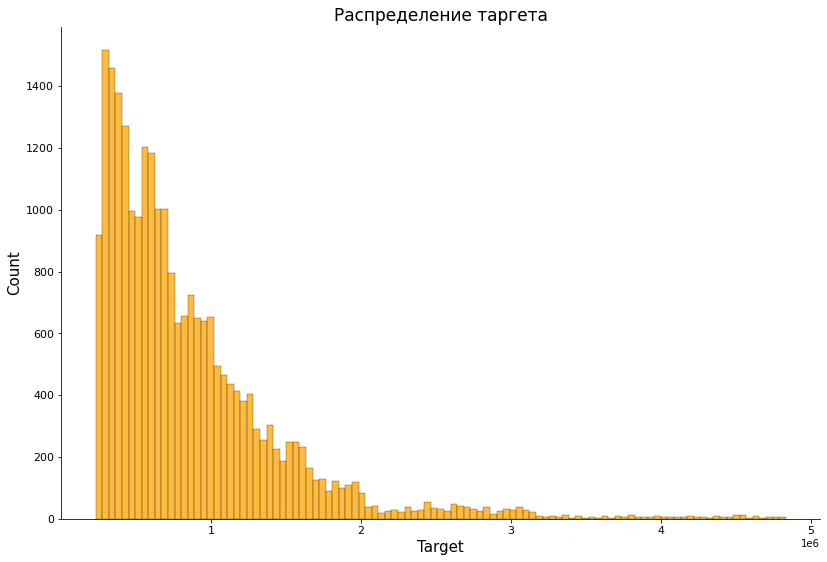

In [26]:
displot = sns.displot(train.target, color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.title('Распределение таргета', fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);
plt.xlabel('Target', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

Видим довольно тяжелый хвост 

# Preprocessing Train and Test

Переводим данные в категориальный тип

In [27]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')

In [28]:
for col in test.columns:
    if test[col].dtype == object:
        test[col] = test[col].astype('category')

Логарифмируем целевую переменную. Получаем нормальное распределение и делаем акцент на стоимость более массовых страховок

In [29]:
train.target = np.log(train.target)

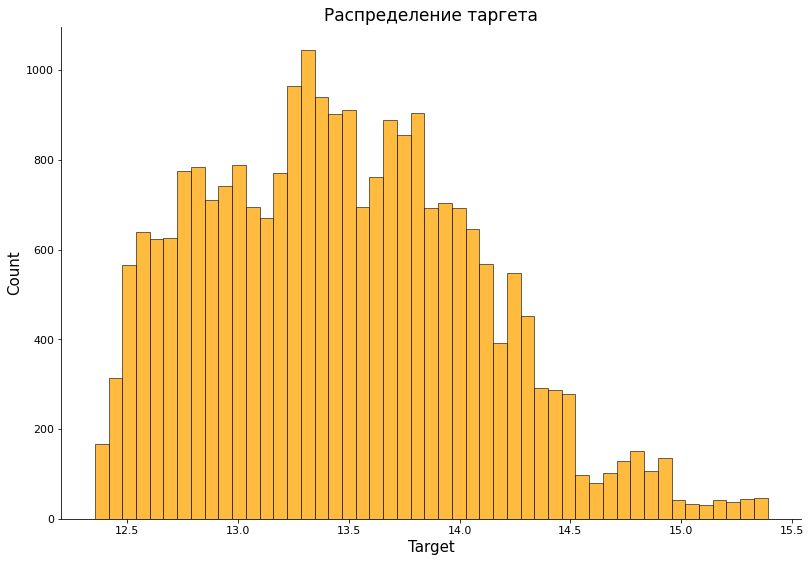

In [30]:
displot = sns.displot(train.target, color='orange')

displot.fig.set_figheight(8)
displot.fig.set_figwidth(13)

plt.title('Распределение таргета', fontsize=17)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11);
plt.xlabel('Target', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.show()

# Modeling

In [31]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RAND)

In [32]:
# DataFrame для записи результатов

metrics = pd.DataFrame(
    index=('MAE', 'MAPE', 'MSE', 'RMSE', 'R2_adjusted', 'RMSLE'))

In [33]:
def r2_adjusted(y_true: list, y_pred: list, X_test: np.array) -> float:
    
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)

# Baseline

## LGBMRegressor

In [34]:
lgmb = LGBMRegressor()

eval_set = [(X_test, y_test)]
lgmb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

LGBMRegressor()

In [35]:
y_pred = np.exp(lgmb.predict(X_test))

metrics['LGBMRegressor'] = ((mean_absolute_error(y_test, y_pred),
                             mean_absolute_percentage_error(y_test, y_pred),
                             mean_squared_error(y_test, y_pred),
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_adjusted(y_test, y_pred, X_test),
                             np.sqrt(mean_squared_log_error(y_test, y_pred))))

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE %:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 adjusted:', r2_adjusted(y_test, y_pred, X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 846012.7472558015
MAPE %: 61239.71453507818
MSE: 1060232036819.8412
RMSE: 1029675.6949738307
R2 adjusted: -2890629587810.4517
RMSLE: 10.8067734412823


## CatBoostRegressor

In [36]:
cat_cols = train.dtypes[train.dtypes == 'category'].index.to_list()

cat = CatBoostRegressor(cat_features=cat_cols, verbose=False)

eval_set = [(X_test, y_test)]
cat.fit(X_train, y_train, eval_set=eval_set)

In [37]:
y_pred = np.exp(cat.predict(X_test))

metrics['CatBoostRegressor'] = ((mean_absolute_error(y_test, y_pred),
                             mean_absolute_percentage_error(y_test, y_pred),
                             mean_squared_error(y_test, y_pred),
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_adjusted(y_test, y_pred, X_test),
                             np.sqrt(mean_squared_log_error(y_test, y_pred))))

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE %:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_adjusted(y_test, y_pred, X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 846819.7007777488
MAPE %: 61291.47436316738
MSE: 1064850359985.734
RMSE: 1031915.8686568077
R2: -2903221040554.558
RMSLE: 10.806669369006089


# GridSearchCV

In [38]:
parametrs = {'learning_rate': [0.055, 0.01, 0.1], 
             'depth': [9, 3, 13], 
             'iterations': [1000, 1100], 
             'bootstrap_type': ['MVS', 'Bayesian'], 
             'reg_lambda': [1, 0.5]}

eval_set = [(X_test, y_test)]
grid_cv = GridSearchCV(cat, param_grid=parametrs, verbose=2, cv=3)

In [39]:
grid_cv.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END bootstrap_type=MVS, depth=9, iterations=1000, learning_rate=0.055, reg_lambda=1; total time=  14.4s
[CV] END bootstrap_type=MVS, depth=9, iterations=1000, learning_rate=0.055, reg_lambda=1; total time=  14.3s
[CV] END bootstrap_type=MVS, depth=9, iterations=1000, learning_rate=0.055, reg_lambda=1; total time=  14.4s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7c5cec7b80>,
             param_grid={'bootstrap_type': ['MVS'], 'depth': [9],
                         'iterations': [1000], 'learning_rate': [0.055],
                         'reg_lambda': [1]},
             verbose=2)

In [40]:
y_pred = np.exp(grid_cv.predict(X_test))

metrics['CatBoostRegressor(GridSearch)'] = ((mean_absolute_error(y_test, y_pred),
                             mean_absolute_percentage_error(y_test, y_pred),
                             mean_squared_error(y_test, y_pred),
                             np.sqrt(mean_squared_error(y_test, y_pred)),
                             r2_adjusted(y_test, y_pred, X_test),
                             np.sqrt(mean_squared_log_error(y_test, y_pred))))

print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE %:', mean_absolute_percentage_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_adjusted(y_test, y_pred, X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))

MAE: 847370.5406064433
MAPE %: 61332.54771994315
MSE: 1064606577004.6206
RMSE: 1031797.7403564231
R2: -2902556387654.307
RMSLE: 10.807246679475492


In [41]:
# Выводим метрики

metrics.T.style.highlight_max(color='orange', axis=0)

# Submission

In [42]:
ids = test['id']
predict = grid_cv.predict(test.drop(['id'], axis=1))

output = pd.DataFrame({'Id': ids, 'target': predict})

In [43]:
output.to_csv('submission.csv', index=False)

In [44]:
output

Id     target
0        1  13.464539
1        2  13.757404
2        3  13.520766
3        4  13.872161
4        5  13.323719
...    ...        ...
3657  3658  12.932302
3658  3659  13.418638
3659  3660  12.748321
3660  3661  12.751606
3661  3662  13.974484

[3662 rows x 2 columns]

# Вывод по эксперементу

Конечно, с реальной бизнес задачей такой подход строго запрещен, ведь понимание данных это уже 50% решения, но для кагла, где нам уже дан loss, собраны все необходимые данные - мы можем применить данный метод и, как я убедился на примере своего кернела, можно даже попасть в топ 12% :)